In [2]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sklearn
import statsmodels.api as sm

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")


In [3]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions from cs019 lab7
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# featurenames - vector of names of predictors
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Plot tree containing only two covariates
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from matplotlib.colors import ListedColormap
# cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step) )

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape( xx.shape )
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=7.5)

In [4]:
df=pd.read_csv("data/finaldata/dftouse.csv")
df.head()

,Unnamed: 0,agency,state,state_abbr,agency_id_nces,county,county_number,num_schools,num_charter_schools,num_pub_schools,report_years,no_report_years,address,city,add_state,zipcode,latitude,longitude,agency_id_state,congressional_code,census_id,offered_g_lowest,pupil_teacher_ratio_dist,pupil_teacher_ratio_ps,totalrev_pp,tlocrev_pp,tsrev_pp,tfedrev_pp,tcurinst_pp,tcurssv_pp,tcuroth_pp,tcursalary_pp,tcurbenefits_pp,totalexp_pp,tcapout_pp,tnonelse_pp,tcurelsc_pp,instexp_pp,tcurelsc_percent,tcurinst_percent,tcuroth_percent,tcuresal_percent,tcurssvc_percent,tfedrev_percent,tlocrev_percent,tsrev_percent,fipst,totd912,ebs912,drp912,...,r_lrev_pt,r_lrev_gst,r_lrev_put,r_lrev_it,r_lrev_aot,r_lrev_pgc,r_lrev_cc,r_lrev_oss,r_lrev_tui,r_lrev_trans,r_lrev_slr,r_lrev_ts,r_lrev_sar,r_lrev_osalserv,r_lrev_sfns,r_lrev_ie,r_lrev_molr,r_lrev_sp,r_lrev_rr,r_lrev_sale,r_lrev_ff,r_lrev_pc,r_srev_gfa,r_srev_sep,r_srev_trans,r_srev_sip,r_srev_cbsp,r_srev_vep,r_srev_codsp,r_srev_bep,r_srev_gt,r_srev_slp,r_srev_aor,r_srev_splea,r_srev_osp,r_srev_ns,r_frev_title1,r_frev_dis,r_frev_cna,r_frev_ems,r_frev_dfs,r_frev_voc,r_frev_ao,r_frev_ns,r_frev_ia,r_frev_be,r_frev_na,r_frev_aofed,RESP_High_Graduation,RESP_Low_Graduation
0,1,21ST CENTURY CHARTER SCH OF GARY,Indiana,IN,1800046,MARION COUNTY,18097,1,1,1,2004-2013,1986-2003,556 WASHINGTON ST,GARY,IN,46402,39.771949,-86.155184,9545,1807,NaN,Kindergarten,15.65,17.14,11111,356,7925,2831,3986,4717,436,4133,1028,11197,1986,72,9139,3986,11.2,43.6,4.8,45.2,51.6,25.5,3.2,71.3,18,0,100,0.0,...,0.000000,0.000000,0.000000,0.000000,0,0,0.070312,0.390625,0.000000,0,0.062500,0.000000,0.000000,0.000000,0,0.000000,0.078125,0.007812,0.000000,0.390625,0,0.00000,0.964599,0.000000,0.000000,0.000000,0.003155,0.000000,0,0,0.003155,0.000000,0.029092,0.000000,0.000000,0,0.606477,0.000000,0.156035,0.000000,0.000000,0.000000,0.176644,0.060844,0,0,0,0.000000,0,1
1,2,21ST CENTURY CYBER CS,Pennsylvania,PA,4200091,CHESTER COUNTY,42029,1,1,1,2001-2013,1986-2000,805 SPRINGDALE DR,EXTON,PA,19341,40.005030,-75.678564,124150002,4206,NaN,6th Grade,28.49,28.49,10557,10285,273,0,5104,3003,0,4199,1456,8732,554,0,8108,5104,18.0,63.0,0.0,51.8,37.0,0.0,97.4,2.6,42,33,483,6.8,...,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.983958,0.005893,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.010149,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.000000,0.000000,0.950617,0.000000,0.000000,0,0,0.000000,0.000000,0.049383,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0.000000,1,0
2,10,A+ ACADEMY,Texas,TX,4800203,DALLAS COUNTY,48113,1,1,1,2000-2013,1986-1999,8225 BRUTON RD,DALLAS,TX,75217,32.767535,-96.660866,057829,4830,NaN,Prekindergarten,16.61,16.61,11015,68,9164,1784,4890,3500,441,5788,477,8864,0,1,8832,4890,5.4,55.4,5.0,65.5,39.6,16.2,0.6,83.2,48,0,228,0.0,...,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0,0.800000,0.000000,0.000000,0.000000,0,0.142857,0.000000,0.000000,0.057143,0.000000,0,0.00000,0.952145,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000211,0.006233,0.040038,0.001373,0,0.351058,0.056430,0.238741,0.033641,0.000000,0.000000,0.320130,0.000000,0,0,0,0.000000,0,1
3,13,A-C CENTRAL CUSD 262,Illinois,IL,1700105,CASS COUNTY,17017,3,0,3,1989-2013,1986-1988,501 EAST BUCHANAN ST,ASHLAND,IL,62612,39.892187,-90.016057,46-009-2620-26,1718,1.450092e+13,Kindergarten,11.86,12.08,11367,4374,5089,1904,4835,4633,498,5741,2112,13200,2204,0,9966,4835,21.2,48.5,5.0,57.6,46.5,16.7,38.5,44.8,17,0,130,0.0,...,0.798637,0.000000,0.000000,0.000000,0,0,0.000000,0.001049,0.000000,0,0.060829,0.009963,0.014683,0.000000,0,0.005244,0.052438,0.027792,0.004195,0.000000,0,0.02517,0.642181,0.049572,0.068049,0.000000,0.004056,0.000901,0,0,0.000000,0.000901,0.015773,0.218567,0.000000,0,0.162651,0.306024,0.087952,0.038554,0.002410,0.000000,0.402410,0.000000,0,0,0,0.000000,0,1
4,14,A-H-S-T COMM SCHOOL DISTRICT,Iowa,IA,1904080,POTTAWATTAMIE COUNTY,19155,2,0,2,1986-2013,NaN,768 SOUTH MAPL

In [30]:
df.shape

(10785, 412)

In [50]:
# Total Number Operational Schools [Public School] 2009-10	num_schools
# Total Number Operational Charter Schools [Public School] 2009-10	num_charter_schools
# Total Number of Public Schools [Public School] 2009-10	num_pub_schools

# Pupil/Teacher Ratio [District] 2009-10	pupil_teacher_ratio_dist
# Total Revenue (TOTALREV) per Pupil (V33) [District Finance] 2009-10	totalrev_pp

# Total Current Expenditures - Instruction (TCURINST) per Pupil (V33) [District Finance] 2009-10	tcurinst_pp
# Total Current Expenditures - Support Services (TCURSSVC) per Pupil (V33) [District Finance] 2009-10	tcurssv_pp
# Total Current Expenditures - Other El-Sec Programs (TCUROTH) per Pupil (V33) [District Finance] 2009-10	tcuroth_pp
# Total Current Expenditures - Salary (Z32) per Pupil (V33) [District Finance] 2009-10	tcursalary_pp
# Total Current Expenditures - Benefits (Z34) per Pupil (V33) [District Finance] 2009-10	tcurbenefits_pp
# Total Expenditures (TOTALEXP) per Pupil (V33) [District Finance] 2009-10	totalexp_pp

# r_stud_re_AIAN	r_stud_re_AIAN
# r_stud_re_AAP	r_stud_re_AAP
# r_stud_re_H	r_stud_re_H
# r_stud_re_B	r_stud_re_B
# r_stud_re_W	r_stud_re_W
# r_stud_re_HNPI	r_stud_re_HNPI
# r_stud_re_Two	r_stud_re_Two

Xnames = [
    'num_schools',
    'num_charter_schools',
    'num_pub_schools',
    'pupil_teacher_ratio_dist',
    'totalrev_pp',
    'tcurinst_pp',
    'tcurssv_pp',
    'tcuroth_pp',
    'tcursalary_pp',
    'tcurbenefits_pp',
    'totalexp_pp',
    'r_stud_re_AAP',
    'r_stud_re_H',
    'r_stud_re_B',
    'r_stud_re_W'
]

# RESP_High_Graduation
# RESP_Low_Graduation

target = 'RESP_High_Graduation'


In [36]:
# Create test/train mask
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [37]:
# make sure we didn't get unlucky in our mask selection
print "% High_Graduation in Training:", np.mean(df['RESP_High_Graduation'][mask])
print "% High_Graduation in Testing:", np.mean(df['RESP_High_Graduation'][~mask])

% High_Graduation in Training: 0.25036428666
% High_Graduation in Testing: 0.245982694685


In [73]:
# Descision Trees
from sklearn import tree

clfTree = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clfTree, Xtrain, ytrain, Xtest, ytest = do_classify(clfTree, parameters, df, 
                                                     Xnames, target, 1, 
                                                     mask=mask, n_jobs = 4, score_func = 'f1')


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'max_depth': 6, 'min_samples_leaf': 5} 0.266216669892 [mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 7}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 8}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 9}, mean: 0.00000, std: 0.00000, params: {'max_depth': 1, 'min_samples_leaf': 10}, mean: 0.09871, std: 0.12197, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.09871, std: 0.12197, params: {'max_depth': 2, 'min_samples_leaf': 2}, me

/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


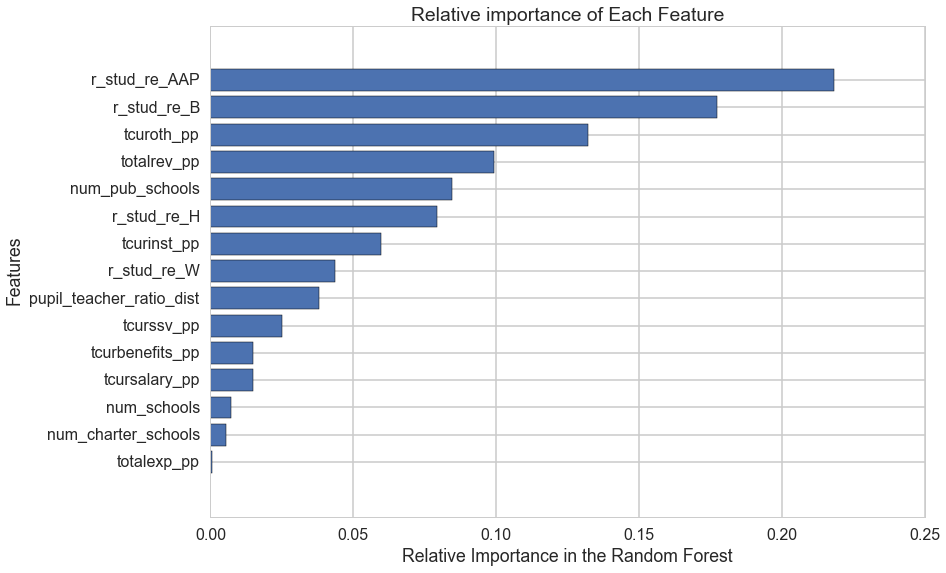

In [74]:
# Plot fot test data
#plot_2tree(plt, Xtrain[:100], Xtest[:100], ytrain[:100], ytest[:100], clfTree1, 
#           lab = ['pupil_teacher_ratio_dist', 'totalexp_pp'], alpha = 1, plot_train = False)
importance_list = clfTree.feature_importances_
name_list = df[Xnames].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [47]:
# Random Forests
from sklearn.ensemble import RandomForestClassifier

clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 10)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       df, Xnames, target, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 3} 0.368961541216 [mean: 0.35652, std: 0.02012, params: {'n_estimators': 1}, mean: 0.26113, std: 0.02565, params: {'n_estimators': 2}, mean: 0.36896, std: 0.02201, params: {'n_estimators': 3}, mean: 0.26977, std: 0.01678, params: {'n_estimators': 4}, mean: 0.35436, std: 0.01959, params: {'n_estimators': 5}, mean: 0.27913, std: 0.00722, params: {'n_estimators': 6}, mean: 0.36095, std: 0.02307, params: {'n_estimators': 7}, mean: 0.29761, std: 0.02214, params: {'n_estimators': 8}, mean: 0.35250, std: 0.01913, params: {'n_estimators': 9}]
############# based on standard predict ################
Accuracy on training data: 0.95
Accuracy on test data:     0.73
[[2081  359]
 [ 528  268]]
########################################################


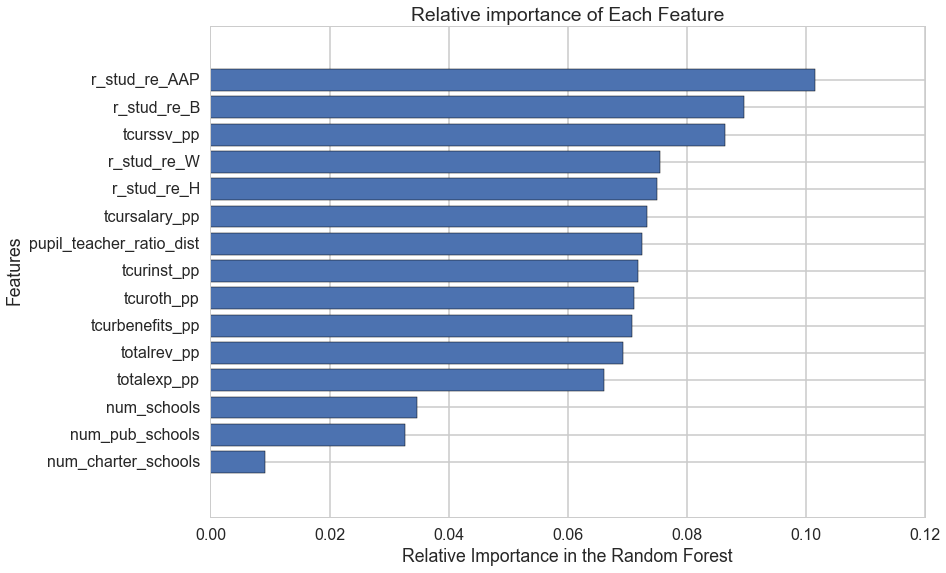

In [53]:
importance_list = clfForest.feature_importances_
name_list = df[Xnames].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()


In [54]:
# ADA Booster
from sklearn.ensemble import AdaBoostClassifier

clfAda = AdaBoostClassifier()

parameters = {"n_estimators": range(10, 60)}
clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, 
                                                       df, Xnames, target, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')

using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 56} 0.288924676155 [mean: 0.22934, std: 0.02728, params: {'n_estimators': 10}, mean: 0.23794, std: 0.03231, params: {'n_estimators': 11}, mean: 0.25700, std: 0.02161, params: {'n_estimators': 12}, mean: 0.26032, std: 0.01190, params: {'n_estimators': 13}, mean: 0.26209, std: 0.03085, params: {'n_estimators': 14}, mean: 0.26381, std: 0.02615, params: {'n_estimators': 15}, mean: 0.26622, std: 0.01726, params: {'n_estimators': 16}, mean: 0.26483, std: 0.02213, params: {'n_estimators': 17}, mean: 0.25785, std: 0.02634, params: {'n_estimators': 18}, mean: 0.26482, std: 0.02473, params: {'n_estimators': 19}, mean: 0.26648, std: 0.02400, params: {'n_estimators': 20}, mean: 0.26644, std: 0.02176, params: {'n_estimators': 21}, mean: 0.27168, std: 0.02518, params: {'n_estimators': 22}, mean: 0.26956, std: 0.02513, params: {'n_estimators': 23}, mean: 0.26924, std: 0.02820, params: {'n_estimators': 24}, mean: 0.27300, std: 0.02153, params: {'n_estimators': 25}, mean: 0.26956,

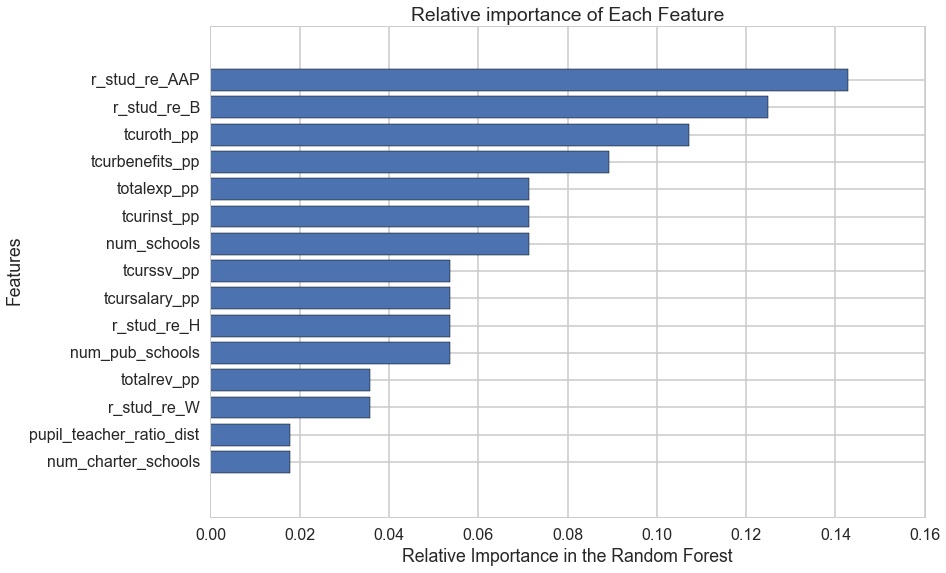

In [55]:
importance_list = clfAda.feature_importances_
name_list = df[Xnames].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [58]:
# Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters, 
                                                       df, Xnames, target, 1, mask=mask, 
                                                       n_jobs = 4, score_func='f1')


using mask


/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 58, 'max_depth': 5} 0.305477265309 [mean: 0.01977, std: 0.01152, params: {'n_estimators': 30, 'max_depth': 1}, mean: 0.01977, std: 0.01152, params: {'n_estimators': 31, 'max_depth': 1}, mean: 0.02393, std: 0.00409, params: {'n_estimators': 32, 'max_depth': 1}, mean: 0.02906, std: 0.00522, params: {'n_estimators': 33, 'max_depth': 1}, mean: 0.02906, std: 0.00522, params: {'n_estimators': 34, 'max_depth': 1}, mean: 0.03608, std: 0.01011, params: {'n_estimators': 35, 'max_depth': 1}, mean: 0.03810, std: 0.00996, params: {'n_estimators': 36, 'max_depth': 1}, mean: 0.04293, std: 0.01720, params: {'n_estimators': 37, 'max_depth': 1}, mean: 0.04999, std: 0.01192, params: {'n_estimators': 38, 'max_depth': 1}, mean: 0.04999, std: 0.01192, params: {'n_estimators': 39, 'max_depth': 1}, mean: 0.05490, std: 0.01563, params: {'n_estimators': 40, 'max_depth': 1}, mean: 0.05192, std: 0.01308, params: {'n_estimators': 41, 'max_depth': 1}, mean: 0.05782, std: 0.01159, params: {'n_e

/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ashwindeo/Dev/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


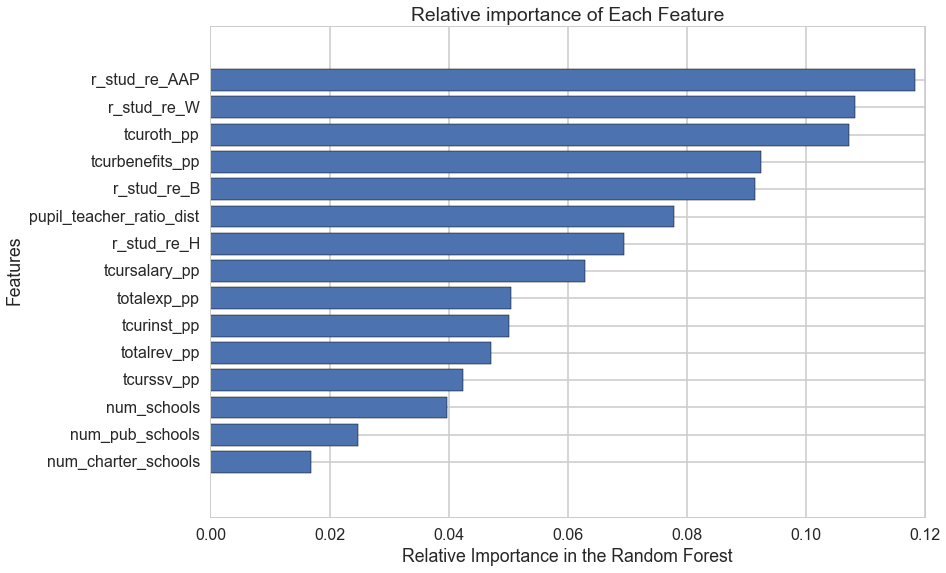

In [59]:
importance_list = clfGB.feature_importances_
name_list = df[Xnames].columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [65]:
# Visualizing Classifiers Using Decision Surfaces
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    


[11 13]


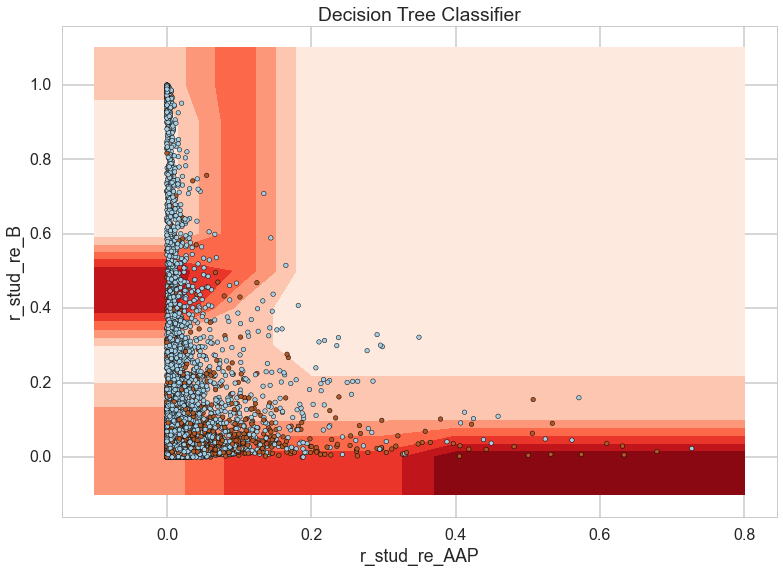

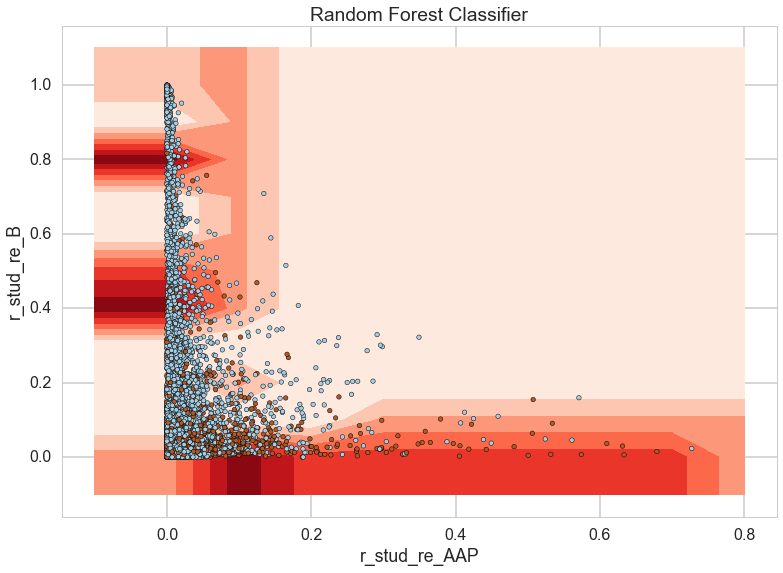

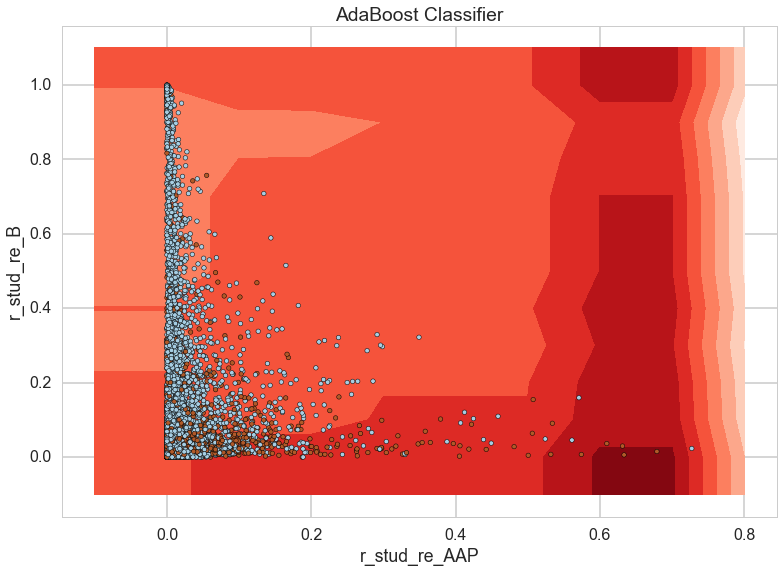

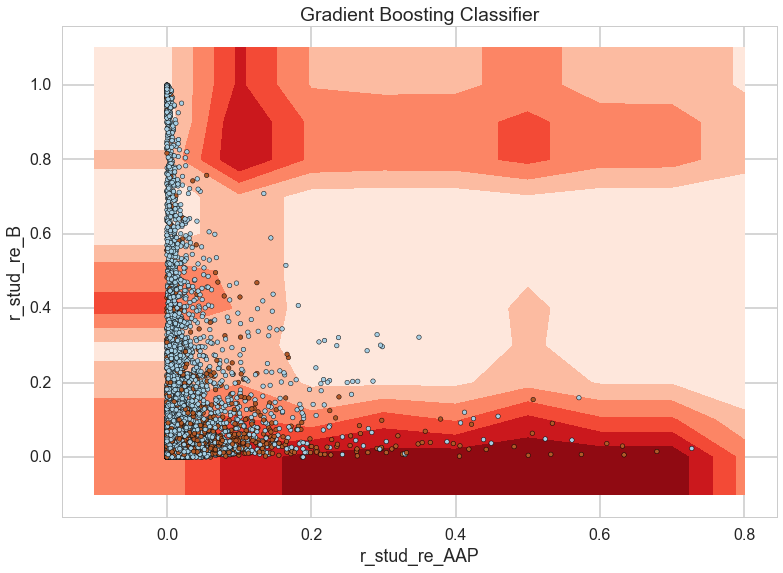

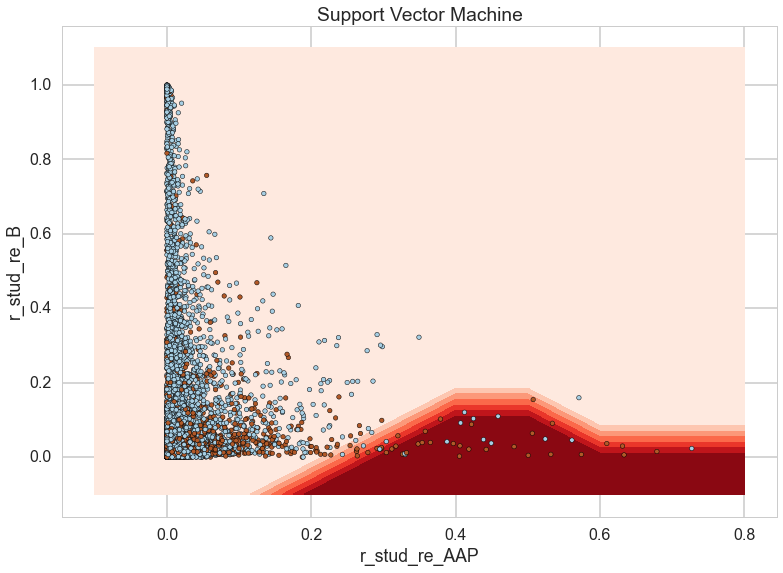

In [92]:
imp_cols = clfTree.feature_importances_.argsort()[::-1][0:2]
print imp_cols

X_imp = df[Xnames][imp_cols].values
Y = df[target].values

classifiers = [clfTree,
               clfForest,
               clfAda,
               clfGB,
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Support Vector Machine']
for c in xrange(5):
    plt.title(titleClassifer[c])
    plt.xlabel(Xnames[imp_cols[0]])
    plt.ylabel(Xnames[imp_cols[1]])
    plot_decision_surface(classifiers[c], X_imp, Y)